## MODELOS ARIMA & LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Se lee la data "original" de Demanda en sector eléctrico

In [2]:
demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Se grafica la data "original" de Demanda en sector eléctrico

Text(0, 0.5, 'Demanda [MMpcd]')

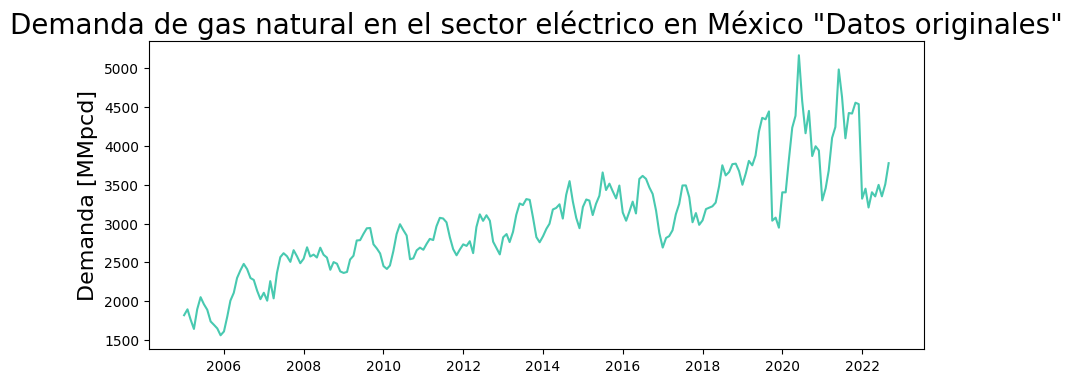

In [3]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda en sector eléctrico en sus compoentes de Tendencia, Estacionalidad y Residual

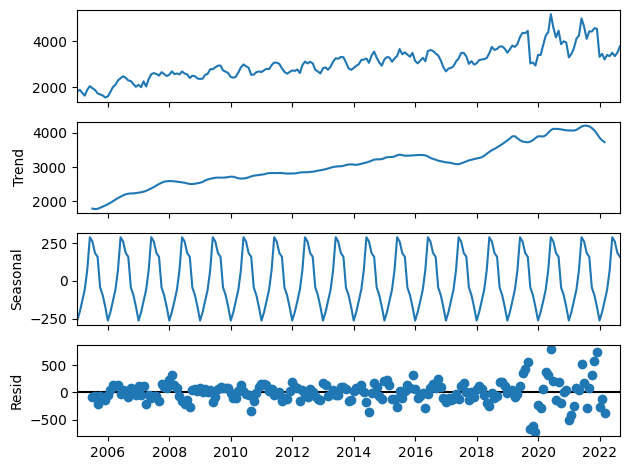

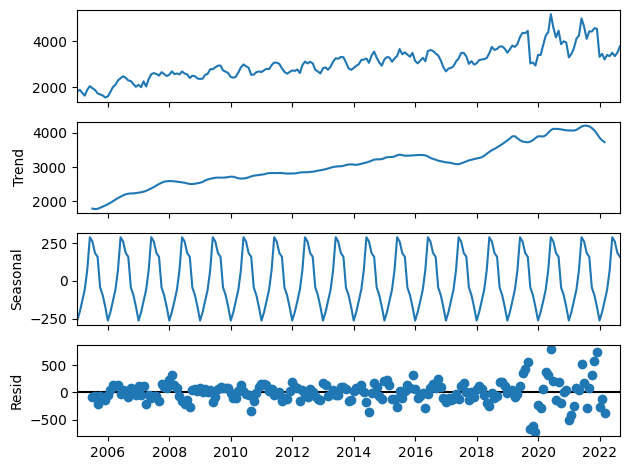

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_electrico_original_seasonal_decomposition = seasonal_decompose(demanda_electrico_original)
demanda_electrico_original_seasonal_decomposition.plot()

Separamos la data original de Demanda de gas natural en el sector eléctrico en data de train y test

In [5]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_electrico_original_train_data = demanda_electrico_original[:-num_test_points]
demanda_electrico_original_test_data = demanda_electrico_original[-num_test_points:]

demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


Se grafica la distribución de los datos "originales escalados" de train de Demanda en sector eléctrico

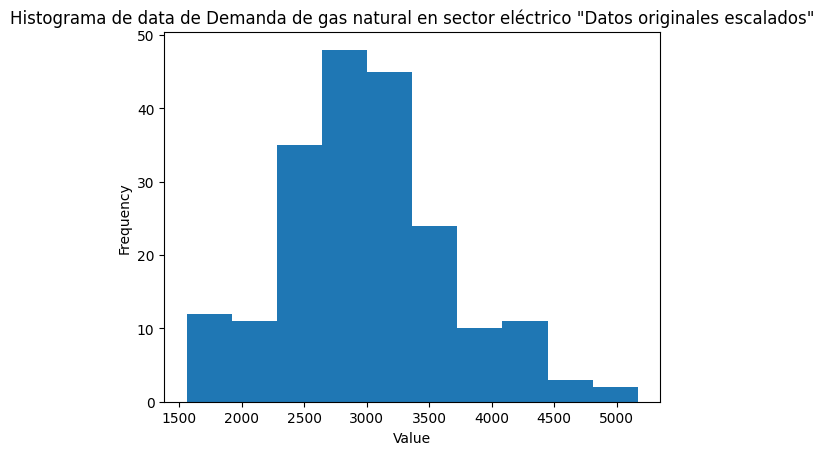

In [6]:
# Generate the histogram
plt.hist(demanda_electrico_original_train_data, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos originales escalados"')

# Display the plot
plt.show()

In [7]:
demanda_electrico_original_train_data.describe()

,Demanded_Gas
count,201.000000
mean,2999.074876
std,667.375493
min,1560.980000
25%,2585.330000
50%,2947.090000
75%,3358.520000
max,5168.270000


Se lleva a cabo una prueba de normalidad a los datos "originales escalados" de train de Demanda en sector eléctrico

In [8]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_original_train_data

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 7.449201490304425
p-value: 0.02412272962118081


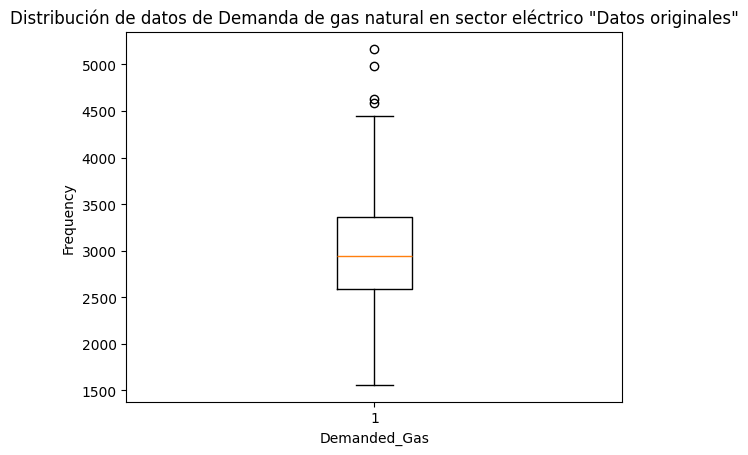

In [9]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_original_train_data)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
demanda_electrico_original_train_data["Demanded_Gas"]

Date
2005-01-01    1819.58
2005-02-01    1895.33
2005-03-01    1765.86
2005-04-01    1642.70
2005-05-01    1895.54
               ...   
2021-05-01    4243.93
2021-06-01    4985.53
2021-07-01    4631.85
2021-08-01    4098.81
2021-09-01    4424.39
Name: Demanded_Gas, Length: 201, dtype: float64

In [12]:
n_input = 24

data = demanda_electrico_original_train_data["Demanded_Gas"]
targets = data 


demanda_electrico_original_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [13]:
demanda_electrico_original_train_generator[176]

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[4445.27, 3037.44, 3076.62, 2947.09, 3402.47, 3402.47, 3819.3 ,
         4235.25, 4387.91, 5168.27, 4581.99, 4163.77, 4451.61, 3869.77,
         3996.14, 3941.12, 3298.43, 3454.21, 3681.3 , 4104.82, 4243.93,
         4985.53, 4631.85, 4098.81]]),
 array([4424.39]))

In [14]:
print("Total number of samples in the original training data = ", len(demanda_electrico_original_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_original_train_generator))


Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


### Se define y entrena la red neuronal FFNN  para el caso de la data original de Demanda en el sector eléctrico

In [15]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal FFNN con capas densas y funcion de activación tipo RELU.

In [17]:
n_input = 24
n_features = 1

# define model
model_FF_electrico_sin_tratamiento = Sequential()
model_FF_electrico_sin_tratamiento.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_FF_electrico_sin_tratamiento.add(Dense(32, activation='relu'))
model_FF_electrico_sin_tratamiento.add(Dense(1))
model_FF_electrico_sin_tratamiento.compile(optimizer='Adam', loss='mse')

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model_FF_electrico_sin_tratamiento.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 24, 64)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model_FF_electrico_sin_tratamiento.fit(demanda_electrico_original_train_generator, epochs=12)

Epoch 1/12
 21/177 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12800376.0000

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4720361.5000
Epoch 2/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 166326.2344
Epoch 3/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 174873.6719
Epoch 4/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 165837.0312
Epoch 5/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 173099.7969
Epoch 6/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 200189.5781
Epoch 7/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 197744.9062
Epoch 8/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 192599.3906
Epoch 9/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 182087.7812
Epoch 10/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 169361.3906
Epoch 11/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 184700.5781
Epoch 12/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 185095.1406


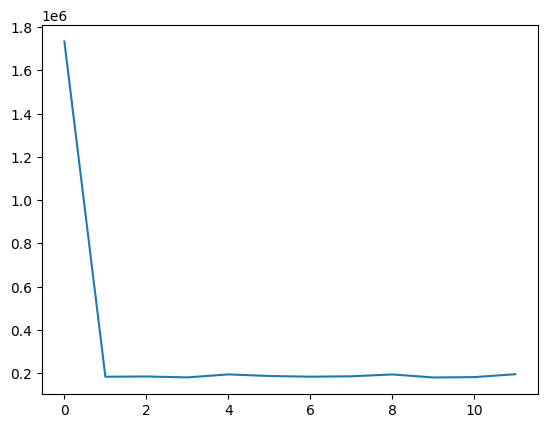

In [20]:
loss_per_epoch_model_FF = model_FF_electrico_sin_tratamiento.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [21]:
n_input = 24
n_features = 1

In [22]:
test_predictions_model_FF_electrico_sin_pretratamiento = []

first_eval_batch = demanda_electrico_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_FF_electrico_sin_tratamiento.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_FF_electrico_sin_pretratamiento.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [23]:
test_predictions_model_FF_electrico_sin_pretratamiento

[4666.5737,
 4921.923,
 5191.1533,
 5475.0195,
 5774.3174,
 6089.8857,
 6422.6094,
 6773.4204,
 7143.302,
 7533.2915,
 7944.482,
 8378.025]

Text(0, 0.5, 'Demanda [MMpcd]')

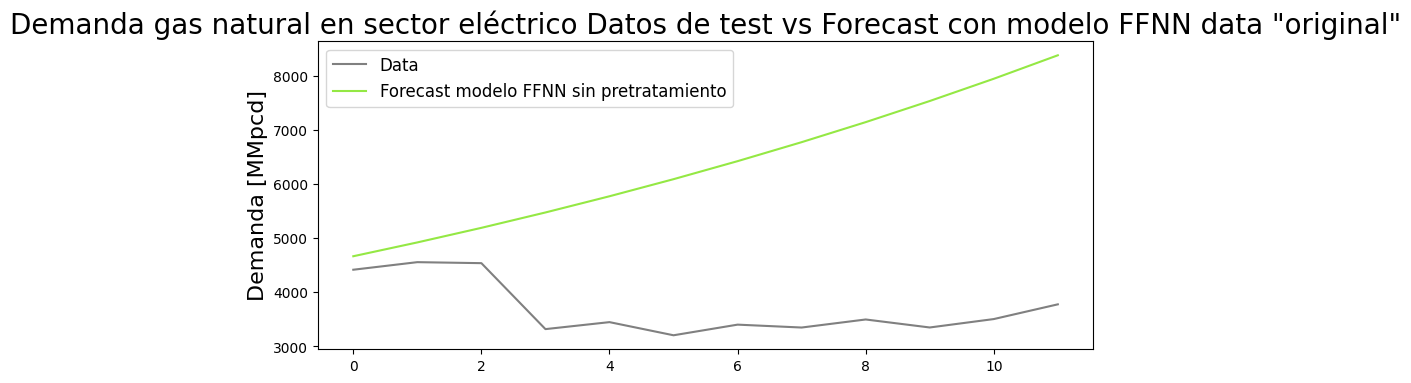

In [24]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_FF_electrico_sin_pretratamiento, color='#94E844')
plt.legend(('Data', 'Forecast modelo FFNN sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo FFNN data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda en el sector eléctrico

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [25]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [26]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico = Sequential()
model_LSTM_electrico.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico.add(Dense(1))
model_LSTM_electrico.compile(optimizer='adam', loss='mse')

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model_LSTM_electrico.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo LSTM

In [28]:
model_LSTM_electrico.fit(demanda_electrico_original_train_generator, epochs=12)


Epoch 1/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 10623502.0000
Epoch 2/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1673196.2500
Epoch 3/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5266789.5000
Epoch 4/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 496169.4062
Epoch 5/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 445740.6250
Epoch 6/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 631462.5625
Epoch 7/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 609548.0625
Epoch 8/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 707140.6875
Epoch 9/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 182810.8438
Epoch 10/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 163180.0781
Epoch 11/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 195217.7656
Epoch 12/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 224901.4219


Se grafica la perdida por epoch

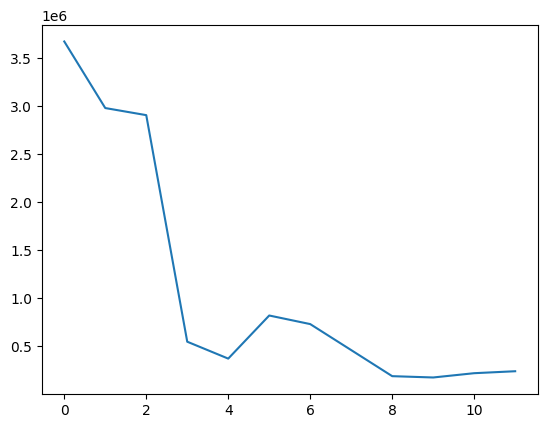

In [29]:
loss_per_epoch_model_FF = model_LSTM_electrico.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_electrico_sin_tratamiento previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [30]:
## demanda_electrico_original_train_generator[-24]

In [31]:
''' 

data = demanda_electrico_original_train_generator

demanda_electrico_train_batch = data[-n_input:]

demanda_electrico_train_batch

'''

' \n\ndata = demanda_electrico_original_train_generator\n\ndemanda_electrico_train_batch = data[-n_input:]\n\ndemanda_electrico_train_batch\n\n'

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [32]:
'''

demanda_electrico_train_batch_reshaped = demanda_electrico_train_batch.reshape(1,n_input, n_features)
demanda_electrico_train_batch_reshaped

'''

'\n\ndemanda_electrico_train_batch_reshaped = demanda_electrico_train_batch.reshape(1,n_input, n_features)\ndemanda_electrico_train_batch_reshaped\n\n'

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [33]:
'''
model_LSTM_electrico.predict(demanda_electrico_train_batch_reshaped)

'''

'\nmodel_LSTM_electrico.predict(demanda_electrico_train_batch_reshaped)\n\n'

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos de test de la demanda de gasd natural en sector eléctrico

In [34]:
'''
demanda_electrico_original_test_data[0]

'''

'\ndemanda_electrico_original_test_data[0]\n\n'

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [35]:
n_input = 24
n_features = 1

In [36]:
first_eval_batch = demanda_electrico_original_train_data[-n_input:]
first_eval_batch

,Demanded_Gas
Date,
2019-10-01,3037.44
2019-11-01,3076.62
2019-12-01,2947.09
2020-01-01,3402.47
2020-02-01,3402.47
2020-03-01,3819.30
2020-04-01,4235.25
2020-05-01,4387.91
2020-06-01,5168.27


In [37]:
test_predictions_model_LSTM_electrico = []

first_eval_batch = demanda_electrico_original_train_data[-n_input:]["Demanded_Gas"].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [38]:
test_predictions_model_LSTM_electrico

[array([4843.6406], dtype=float32),
 array([4043.5115], dtype=float32),
 array([4025.1555], dtype=float32),
 array([4438.3867], dtype=float32),
 array([4321.4575], dtype=float32),
 array([4317.1445], dtype=float32),
 array([4272.3247], dtype=float32),
 array([3855.9495], dtype=float32),
 array([4316.5215], dtype=float32),
 array([4306.5176], dtype=float32),
 array([4792.275], dtype=float32),
 array([4029.8716], dtype=float32)]

Se grafican los 12 meses de test vs el forecast del modelo LSTM con la data de entrenamiento normalizada con MinMaxScaler()

Text(0, 0.5, 'Demanda [MMpcd]')

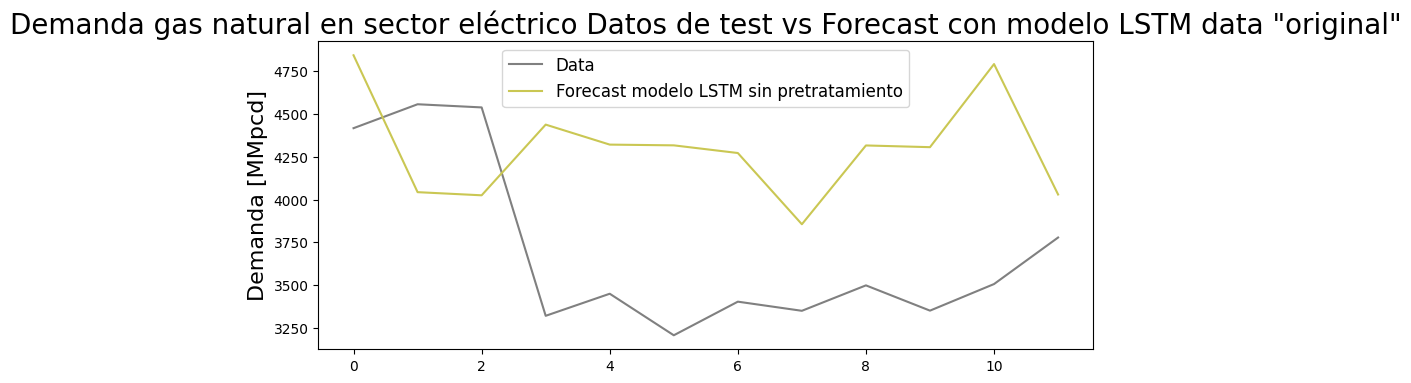

In [39]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo LSTM data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo FFNN sin la data pretratada

In [40]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_electrico = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico)
RMSE_predictions_model_LSTM_electrico= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico))

print('MAPE:', MAPE_predictions_model_LSTM_electrico)
print('RMSE:', RMSE_predictions_model_LSTM_electrico)

MAPE: 0.21802580413677386
RMSE: 829.6813274773324


### Se define y entrena modelo ARIMA para el caso de la data original de Demanda en el sector eléctrico

In [41]:
##Create the model
model_ARIMA_electrico_original = ARIMA (demanda_electrico_original_train_data, order=(4,1,4))

##Fit the model
start = time()
model_ARIMA_electrico_original_fit = model_ARIMA_electrico_original.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_electrico_original_fit.summary())

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\base\mo

Model fitting time 14.808757305145264
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  201
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -1333.396
Date:                Mon, 22 Apr 2024   AIC                           2684.793
Time:                        15:54:45   BIC                           2714.478
Sample:                    01-01-2005   HQIC                          2696.806
                         - 09-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8308      0.074     11.202      0.000       0.685       0.976
ar.L2         -0.4252      0.068     -6.294      0.000      -0.558      -0.293
ar.L3         

In [42]:
##get prediction start and end dates 
pred_model_ARIMA_electrico_start_date = demanda_electrico_original_test_data.index[0]
pred_model_ARIMA_electrico_end_date = demanda_electrico_original_test_data.index[-1]

##get the predictors and residuals 
predictions_model_ARIMA_electrico_original = model_ARIMA_electrico_original_fit.predict(start=pred_model_ARIMA_electrico_start_date, end= pred_model_ARIMA_electrico_end_date)
predictions_model_ARIMA_electrico_original


2021-10-01    4116.919792
2021-11-01    3938.661142
2021-12-01    4075.783781
2022-01-01    3892.115780
2022-02-01    3786.677023
2022-03-01    4047.242794
2022-04-01    4032.864798
2022-05-01    3974.030171
2022-06-01    4246.932479
2022-07-01    4265.558507
2022-08-01    4126.053842
2022-09-01    4289.164033
Freq: MS, Name: predicted_mean, dtype: float64

In [43]:
test_predictions_model_LSTM_electrico

[array([4843.6406], dtype=float32),
 array([4043.5115], dtype=float32),
 array([4025.1555], dtype=float32),
 array([4438.3867], dtype=float32),
 array([4321.4575], dtype=float32),
 array([4317.1445], dtype=float32),
 array([4272.3247], dtype=float32),
 array([3855.9495], dtype=float32),
 array([4316.5215], dtype=float32),
 array([4306.5176], dtype=float32),
 array([4792.275], dtype=float32),
 array([4029.8716], dtype=float32)]

Text(0, 0.5, 'Demanda [MMpcd]')

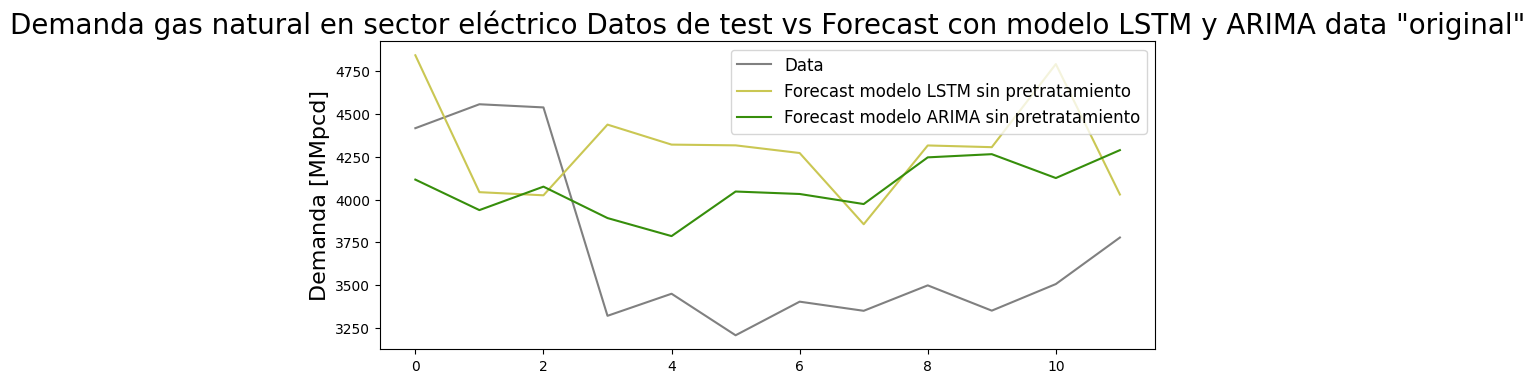

In [44]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento', 'Forecast modelo ARIMA sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo LSTM y ARIMA data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [45]:
outlier_threshold = 1.25

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_electrico_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [46]:
demanda_electrico_original_train_para_tratamiento =demanda_electrico_original_train_data.copy()
demanda_electrico_original_train_para_tratamiento

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


In [47]:
demanda_electrico_train_pretratamiento_media = remove_replace_outliers_media(demanda_electrico_original_train_para_tratamiento['Demanded_Gas'])
demanda_electrico_train_pretratamiento_media

Date
2005-01-01    1819.580000
2005-02-01    1895.330000
2005-03-01    1765.860000
2005-04-01    1642.700000
2005-05-01    1895.540000
                 ...     
2021-05-01    4243.930000
2021-06-01    2930.477354
2021-07-01    2930.477354
2021-08-01    4098.810000
2021-09-01    2930.477354
Name: Demanded_Gas, Length: 201, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

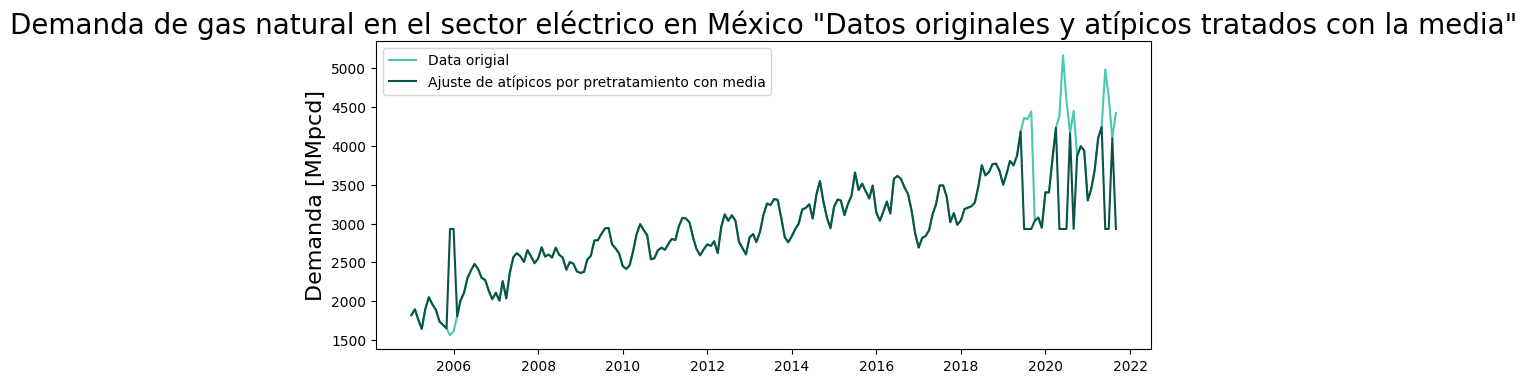

In [48]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original_train_data, color='#48C9B0')
plt.plot(demanda_electrico_train_pretratamiento_media,color='#0B5345')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales y atípicos tratados con la media"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

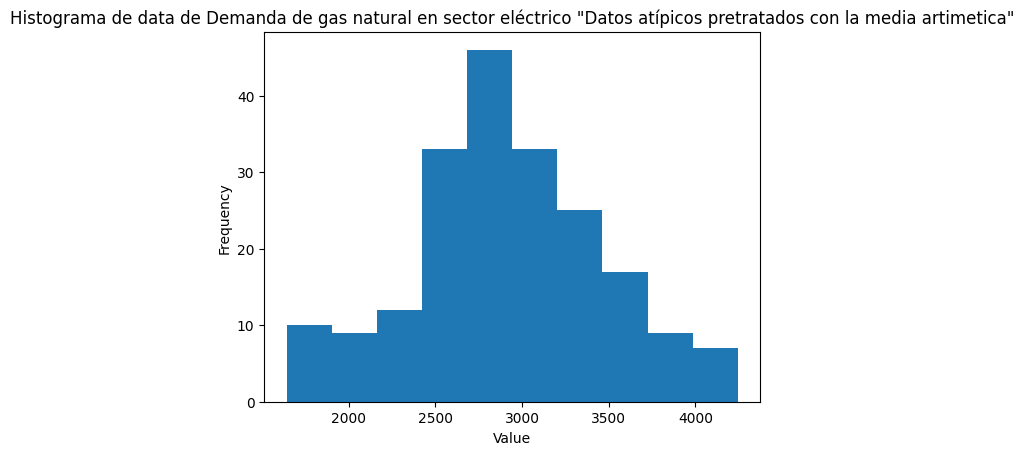

In [49]:
# Generate the histogram
plt.hist(demanda_electrico_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

In [50]:
demanda_electrico_train_pretratamiento_media.describe()

count     201.000000
mean     2930.477354
std       541.028108
min      1642.700000
25%      2598.570000
50%      2930.477354
75%      3270.330000
max      4243.930000
Name: Demanded_Gas, dtype: float64

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda en sector eléctrico para el caso de pretratamiento con la media artimetica

In [51]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 0.003123599324221352
p-value: 0.9984394193123011


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

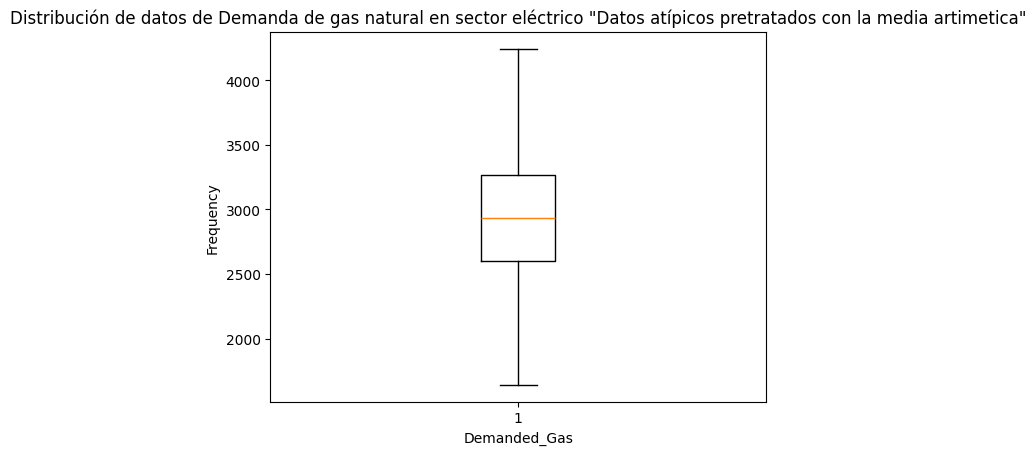

In [52]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [53]:
n_input = 24

data = demanda_electrico_train_pretratamiento_media
targets = data 

demanda_electrico_train_generator_pretratamiento_media = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [54]:
demanda_electrico_train_generator_pretratamiento_media[0]

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[1819.58     , 1895.33     , 1765.86     , 1642.7      ,
         1895.54     , 2051.72     , 1962.05     , 1889.66     ,
         1739.1      , 1695.92     , 1648.95     , 2930.4773545,
         2930.4773545, 1806.33     , 2006.88     , 2108.31     ,
         2298.9      , 2398.88     , 2480.62     , 2413.08     ,
         2298.49     , 2273.91     , 2134.41     , 2025.98     ]]),
 array([2108.85]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [55]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_pretratamiento_media)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_media))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU.  

In [56]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)



In [57]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico_pretratamiento_media = Sequential()
model_LSTM_electrico_pretratamiento_media.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_pretratamiento_media.add(Dense(1))
model_LSTM_electrico_pretratamiento_media.compile(optimizer='adam', loss='mse')

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
model_LSTM_electrico_pretratamiento_media.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [59]:
model_LSTM_electrico_pretratamiento_media.fit(demanda_electrico_train_generator_pretratamiento_media, epochs=12)

Epoch 1/12
 14/177 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9557590.0000 

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 9770590.0000
Epoch 2/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9394095.0000
Epoch 3/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9314654.0000
Epoch 4/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9482978.0000
Epoch 5/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9767794.0000
Epoch 6/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9760996.0000
Epoch 7/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9345317.0000
Epoch 8/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9614884.0000
Epoch 9/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9792648.0000
Epoch 10/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9345271.0000
Epoch 11/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9152277.0000
Epoch 12/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9753959.0000


Se grafica la perdida por epoch 

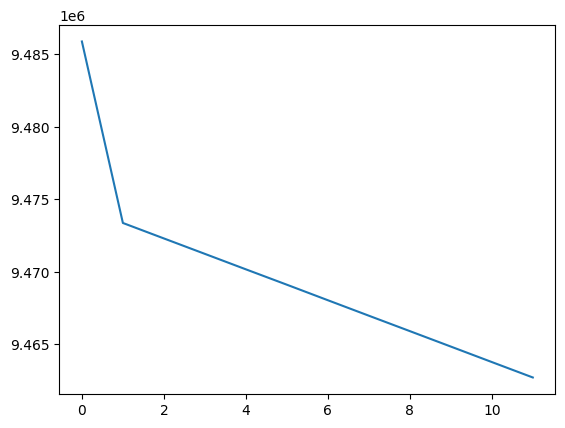

In [60]:
loss_per_epoch = model_LSTM_electrico_pretratamiento_media.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [61]:
demanda_electrico_train_batch_pretratamiento_media = demanda_electrico_train_pretratamiento_media[-n_input:]


demanda_electrico_train_batch_pretratamiento_media

Date
2019-10-01    3037.440000
2019-11-01    3076.620000
2019-12-01    2947.090000
2020-01-01    3402.470000
2020-02-01    3402.470000
2020-03-01    3819.300000
2020-04-01    4235.250000
2020-05-01    2930.477354
2020-06-01    2930.477354
2020-07-01    2930.477354
2020-08-01    4163.770000
2020-09-01    2930.477354
2020-10-01    3869.770000
2020-11-01    3996.140000
2020-12-01    3941.120000
2021-01-01    3298.430000
2021-02-01    3454.210000
2021-03-01    3681.300000
2021-04-01    4104.820000
2021-05-01    4243.930000
2021-06-01    2930.477354
2021-07-01    2930.477354
2021-08-01    4098.810000
2021-09-01    2930.477354
Name: Demanded_Gas, dtype: float64

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [62]:
demanda_electrico_train_batch_pretratamiento_media_reshaped = demanda_electrico_train_batch_pretratamiento_media.values.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_media_reshaped

array([[[3037.44     ],
        [3076.62     ],
        [2947.09     ],
        [3402.47     ],
        [3402.47     ],
        [3819.3      ],
        [4235.25     ],
        [2930.4773545],
        [2930.4773545],
        [2930.4773545],
        [4163.77     ],
        [2930.4773545],
        [3869.77     ],
        [3996.14     ],
        [3941.12     ],
        [3298.43     ],
        [3454.21     ],
        [3681.3      ],
        [4104.82     ],
        [4243.93     ],
        [2930.4773545],
        [2930.4773545],
        [4098.81     ],
        [2930.4773545]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [63]:
model_LSTM_electrico_pretratamiento_media.predict(demanda_electrico_train_batch_pretratamiento_media_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


array([[2.0978858]], dtype=float32)

Y se compara el valor de forecast del modelo LSTM + pretratamiento media + normalizacion con los datos de test de la demanda de gas natural en sector eléctrico

In [64]:
demanda_electrico_original_test_data

,Demanded_Gas
Date,
2021-10-01,4417.51
2021-11-01,4557.36
2021-12-01,4538.89
2022-01-01,3320.75
2022-02-01,3449.80
2022-03-01,3206.96
2022-04-01,3403.44
2022-05-01,3350.03
2022-06-01,3498.70


Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [65]:
n_input = 24
n_features = 1

In [66]:
demanda_electrico_train_pretratamiento_media[-n_input:]

Date
2019-10-01    3037.440000
2019-11-01    3076.620000
2019-12-01    2947.090000
2020-01-01    3402.470000
2020-02-01    3402.470000
2020-03-01    3819.300000
2020-04-01    4235.250000
2020-05-01    2930.477354
2020-06-01    2930.477354
2020-07-01    2930.477354
2020-08-01    4163.770000
2020-09-01    2930.477354
2020-10-01    3869.770000
2020-11-01    3996.140000
2020-12-01    3941.120000
2021-01-01    3298.430000
2021-02-01    3454.210000
2021-03-01    3681.300000
2021-04-01    4104.820000
2021-05-01    4243.930000
2021-06-01    2930.477354
2021-07-01    2930.477354
2021-08-01    4098.810000
2021-09-01    2930.477354
Name: Demanded_Gas, dtype: float64

In [67]:
test_predictions_model_LSTM_electrico_pretratamiento_media  = []

first_eval_batch = demanda_electrico_train_pretratamiento_media[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_pretratamiento_media.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_pretratamiento_media.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [68]:
test_predictions_model_LSTM_electrico_pretratamiento_media

[array([2.0978858], dtype=float32),
 array([1009.6881], dtype=float32),
 array([7.536832], dtype=float32),
 array([-168.90695], dtype=float32),
 array([-86.30243], dtype=float32),
 array([2.9327626], dtype=float32),
 array([10.515117], dtype=float32),
 array([8.8424635], dtype=float32),
 array([4.8377266], dtype=float32),
 array([15.408001], dtype=float32),
 array([4.159709], dtype=float32),
 array([7.381652], dtype=float32)]

In [69]:
demanda_electrico_original_test_data['Demanded_Gas'].values

array([4417.51, 4557.36, 4538.89, 3320.75, 3449.8 , 3206.96, 3403.44,
       3350.03, 3498.7 , 3350.97, 3506.42, 3778.37])

Text(0, 0.5, 'Demanda [MMpcd]')

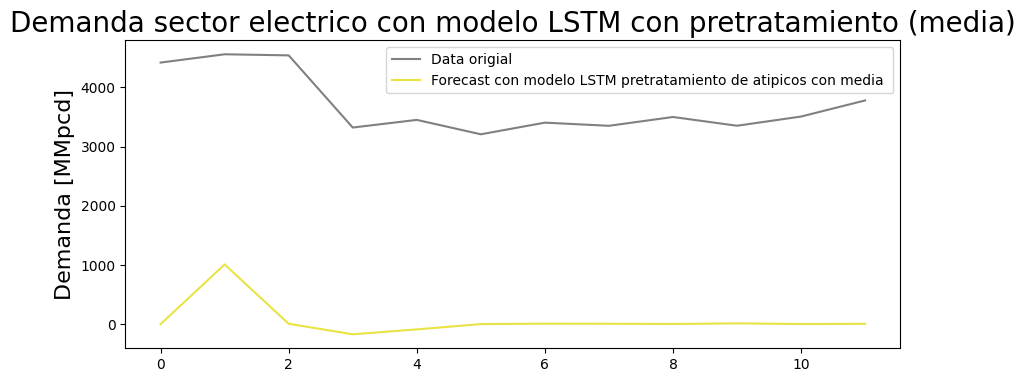

In [70]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM pretratamiento de atipicos con media '))

plt.title('Demanda sector electrico con modelo LSTM con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [71]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_electrico_pretratamiento_media = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_media)
RMSE_test_predictions_model_LSTM_electrico_pretratamiento_media = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_media))

print('MAPE:', MAPE_test_predictions_model_LSTM_electrico_pretratamiento_media)
print('RMSE:', RMSE_test_predictions_model_LSTM_electrico_pretratamiento_media)

MAPE: 0.9863691587815321
RMSE: 3652.136580131049


Se muestra la comparación del forecast de demanda electrico con modelo FFNN entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

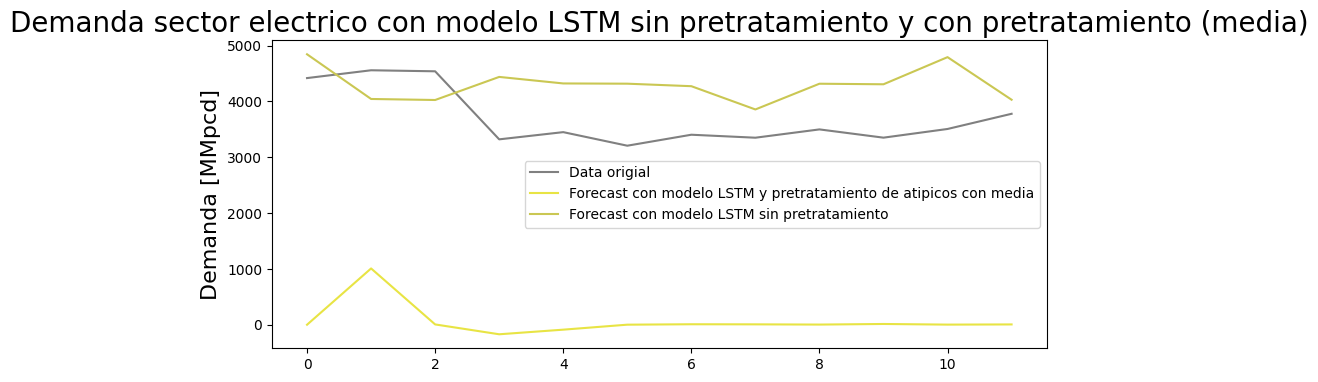

In [72]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Apliquemos un modelo ARIMA a nuestra data de Demanda de gas natural en sector eléctrico 'Datos atipicos con tratamiento media'

In [73]:
##Create the model
model_ARIMA_electrico_tratamiento_media = ARIMA (demanda_electrico_train_pretratamiento_media, order=(3,1,3))

##Fit the model
start = time()
model_ARIMA_electrico_tratamiento_media_fit = model_ARIMA_electrico_tratamiento_media.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_electrico_tratamiento_media_fit.summary())

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitting time 2.4131643772125244
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  201
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1407.446
Date:                Mon, 22 Apr 2024   AIC                           2828.893
Time:                        15:55:23   BIC                           2851.981
Sample:                    01-01-2005   HQIC                          2838.236
                         - 09-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7248      0.114     -6.365      0.000      -0.948      -0.502
ar.L2         -0.4120      0.092     -4.464      0.000      -0.593      -0.231
ar.L3         

In [74]:
##get prediction start and end dates 
pred_model_ARIMA_electrico_start_date = demanda_electrico_original_test_data.index[0]
pred_model_ARIMA_electrico_end_date = demanda_electrico_original_test_data.index[-1]

In [75]:
##get the predictors and residuals 
predictions_model_ARIMA_electrico_tratamiento_media = model_ARIMA_electrico_tratamiento_media_fit.predict(start=pred_model_ARIMA_electrico_start_date, end= pred_model_ARIMA_electrico_end_date)
print(predictions_model_ARIMA_electrico_tratamiento_media)

2021-10-01    3014.293283
2021-11-01    3358.948652
2021-12-01    3525.310372
2022-01-01    3284.654503
2022-02-01    3480.697233
2022-03-01    3481.251601
2022-04-01    3337.143140
2022-05-01    3492.644489
2022-06-01    3439.444342
2022-07-01    3376.252915
2022-08-01    3484.644261
2022-09-01    3418.196609
Freq: MS, Name: predicted_mean, dtype: float64


In [76]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_electrico_tratamiento_media = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_media)
RMSE_predictions_model_ARIMA_electrico_tratamiento_media= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_media))

print('MAPE:', MAPE_predictions_model_ARIMA_electrico_tratamiento_media)
print('RMSE:', RMSE_predictions_model_ARIMA_electrico_tratamiento_media)

MAPE: 0.09144531743328203
RMSE: 623.7739750209349


Text(0, 0.5, 'Demanda [MMpcd]')

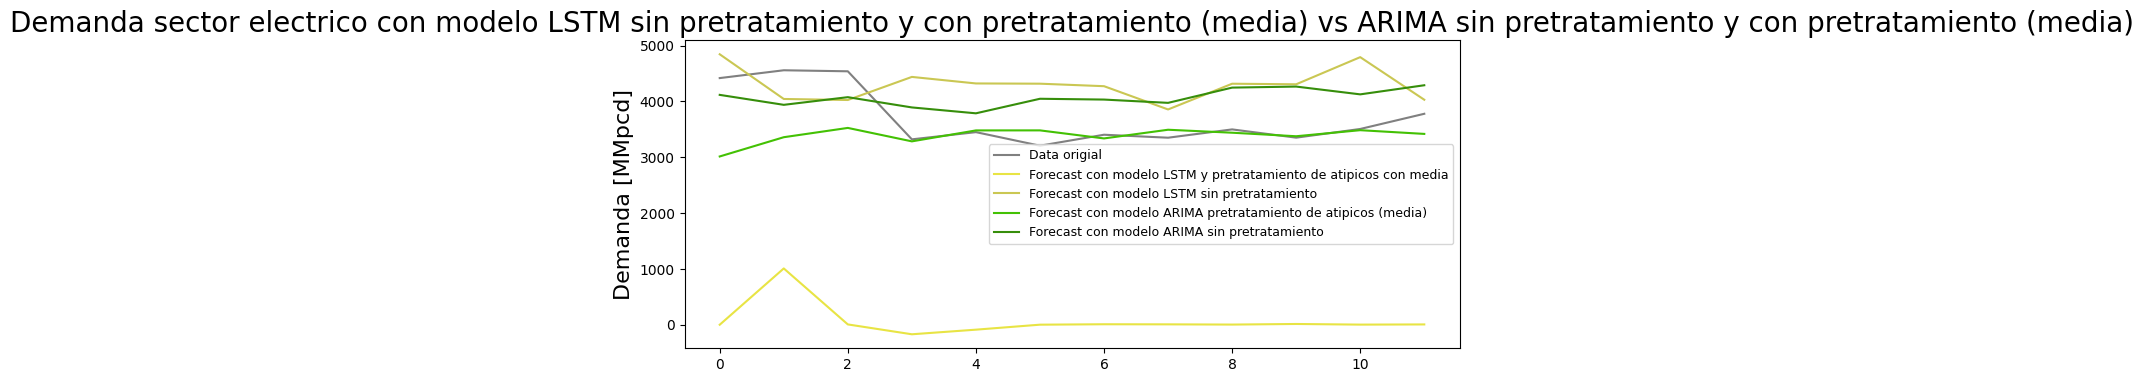

In [77]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.plot(predictions_model_ARIMA_electrico_tratamiento_media.values,color='#43C104')
plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento', 'Forecast con modelo ARIMA pretratamiento de atipicos (media)','Forecast con modelo ARIMA sin pretratamiento ' ), fontsize=9)

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media) vs ARIMA sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [78]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [79]:
demanda_electrico_original_train_para_tratamiento2 =demanda_electrico_original_train_data.copy()
demanda_electrico_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


In [80]:
demanda_electrico_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_electrico_original_train_para_tratamiento2['Demanded_Gas'])
demanda_electrico_train_pretratamiento_mediana

Date
2005-01-01    1819.58
2005-02-01    1895.33
2005-03-01    1765.86
2005-04-01    2939.05
2005-05-01    1895.54
               ...   
2021-05-01    4243.93
2021-06-01    2939.05
2021-07-01    2939.05
2021-08-01    4098.81
2021-09-01    2939.05
Name: Demanded_Gas, Length: 201, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

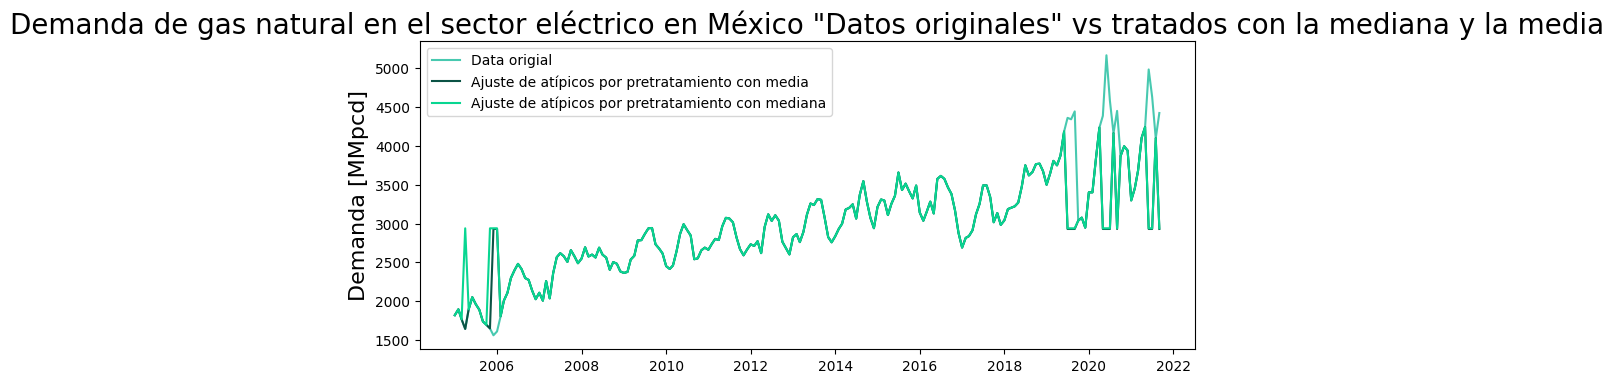

In [81]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original_train_data, color='#48C9B0')
plt.plot(demanda_electrico_train_pretratamiento_media,color='#0B5345')
plt.plot(demanda_electrico_train_pretratamiento_mediana, color= '#08D691')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con mediana'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales" vs tratados con la mediana y la media', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de mediana de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

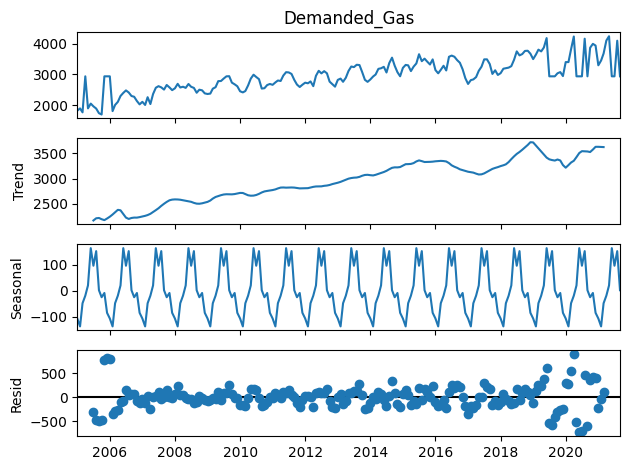

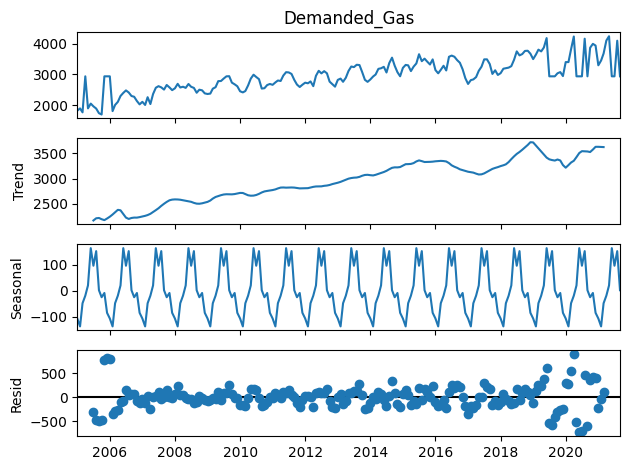

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_electrico_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_electrico_train_pretratamiento_mediana)
demanda_electrico_train_pretratamiento_mediana_seasonal_decomposition.plot()


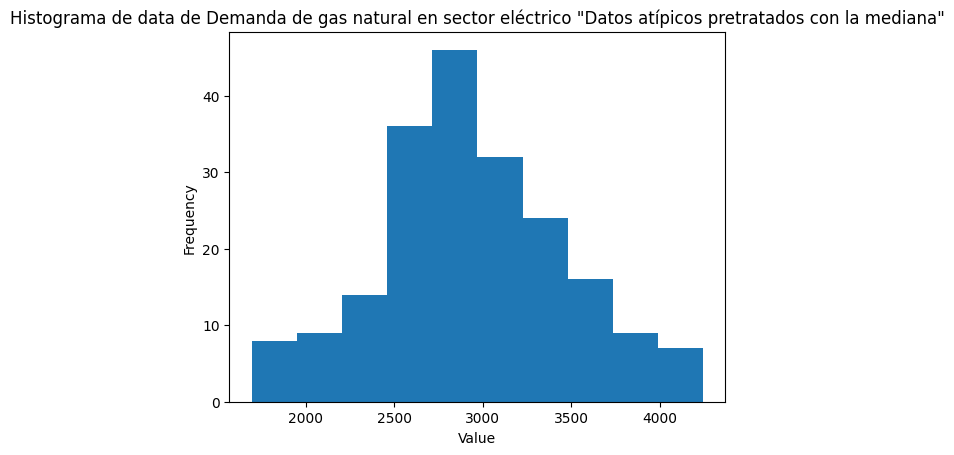

In [83]:
# Generate the histogram
plt.hist(demanda_electrico_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

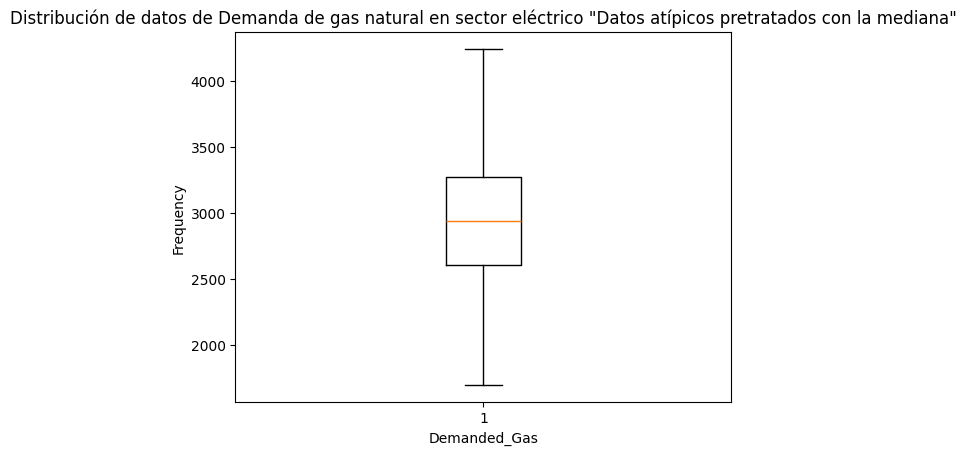

In [84]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_train_pretratamiento_mediana)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

In [85]:
demanda_electrico_train_pretratamiento_mediana.describe()

count     201.000000
mean     2943.857065
std       525.388648
min      1695.920000
25%      2602.730000
50%      2939.050000
75%      3270.330000
max      4243.930000
Name: Demanded_Gas, dtype: float64

In [86]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 0.12060749433842395
p-value: 0.941478518713411


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [87]:
n_input = 24

data = demanda_electrico_train_pretratamiento_mediana
targets = data 

demanda_electrico_train_generator_pretratamiento_mediana = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_electrico_train_generator_pretratamiento_mediana[0]

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[1819.58, 1895.33, 1765.86, 2939.05, 1895.54, 2051.72, 1962.05,
         1889.66, 1739.1 , 1695.92, 2939.05, 2939.05, 2939.05, 1806.33,
         2006.88, 2108.31, 2298.9 , 2398.88, 2480.62, 2413.08, 2298.49,
         2273.91, 2134.41, 2025.98]]),
 array([2108.85]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [88]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_mediana))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector electrico con pretratamiento de mediana 

In [89]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico_pretrataminto_mediana = Sequential()

model_LSTM_electrico_pretrataminto_mediana.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_pretrataminto_mediana.add(Dense(1))
model_LSTM_electrico_pretrataminto_mediana.compile(optimizer='adam', loss='mse')

model_LSTM_electrico_pretrataminto_mediana.summary()

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Se entrena el modelo 

In [90]:
model_LSTM_electrico_pretrataminto_mediana.fit(demanda_electrico_train_generator_pretratamiento_mediana, epochs=15)

Epoch 1/15


 37/177 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16426723.0000

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 11441203.0000
Epoch 2/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2254680.2500
Epoch 3/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 685473.6875
Epoch 4/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 124615.7969
Epoch 5/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 146714.0781
Epoch 6/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 158577.0000
Epoch 7/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 103419.7109
Epoch 8/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 110720.5859
Epoch 9/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 86758.6172
Epoch 10/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 84540.9297
Epoch 11/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 108288.5078
Epoch 12/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 111109.2578
Epoch 13/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 112779.6484
Epoch 14/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 106526.

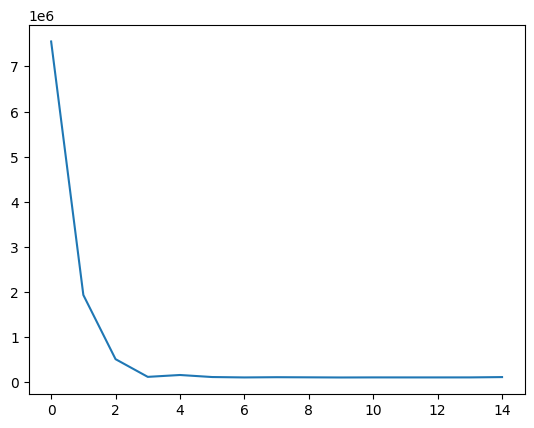

In [91]:
loss_per_epoch = model_LSTM_electrico_pretrataminto_mediana.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [92]:
demanda_electrico_train_pretratamiento_mediana

Date
2005-01-01    1819.58
2005-02-01    1895.33
2005-03-01    1765.86
2005-04-01    2939.05
2005-05-01    1895.54
               ...   
2021-05-01    4243.93
2021-06-01    2939.05
2021-07-01    2939.05
2021-08-01    4098.81
2021-09-01    2939.05
Name: Demanded_Gas, Length: 201, dtype: float64

In [93]:
demanda_electrico_train_batch_pretratamiento_mediana = demanda_electrico_train_pretratamiento_mediana[-n_input:]


demanda_electrico_train_batch_pretratamiento_mediana

Date
2019-10-01    3037.44
2019-11-01    3076.62
2019-12-01    2947.09
2020-01-01    3402.47
2020-02-01    3402.47
2020-03-01    3819.30
2020-04-01    4235.25
2020-05-01    2939.05
2020-06-01    2939.05
2020-07-01    2939.05
2020-08-01    4163.77
2020-09-01    2939.05
2020-10-01    3869.77
2020-11-01    3996.14
2020-12-01    3941.12
2021-01-01    3298.43
2021-02-01    3454.21
2021-03-01    3681.30
2021-04-01    4104.82
2021-05-01    4243.93
2021-06-01    2939.05
2021-07-01    2939.05
2021-08-01    4098.81
2021-09-01    2939.05
Name: Demanded_Gas, dtype: float64

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [94]:
demanda_electrico_train_batch_pretratamiento_mediana_reshaped = demanda_electrico_train_batch_pretratamiento_mediana.values.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_mediana_reshaped

array([[[3037.44],
        [3076.62],
        [2947.09],
        [3402.47],
        [3402.47],
        [3819.3 ],
        [4235.25],
        [2939.05],
        [2939.05],
        [2939.05],
        [4163.77],
        [2939.05],
        [3869.77],
        [3996.14],
        [3941.12],
        [3298.43],
        [3454.21],
        [3681.3 ],
        [4104.82],
        [4243.93],
        [2939.05],
        [2939.05],
        [4098.81],
        [2939.05]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [95]:
model_LSTM_electrico_pretrataminto_mediana.predict(demanda_electrico_train_batch_pretratamiento_mediana_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


array([[3523.9116]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [96]:
n_input = 24
n_features = 1

In [97]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana  = []

first_eval_batch = demanda_electrico_train_pretratamiento_mediana[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_pretrataminto_mediana.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_pretratamiento_mediana.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [98]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana

[array([3523.9116], dtype=float32),
 array([3627.2878], dtype=float32),
 array([3572.1453], dtype=float32),
 array([3824.3674], dtype=float32),
 array([3704.9275], dtype=float32),
 array([3709.2786], dtype=float32),
 array([3502.5142], dtype=float32),
 array([3506.6665], dtype=float32),
 array([3710.729], dtype=float32),
 array([3589.724], dtype=float32),
 array([3626.33], dtype=float32),
 array([3675.838], dtype=float32)]

Text(0, 0.5, 'Demanda [MMpcd]')

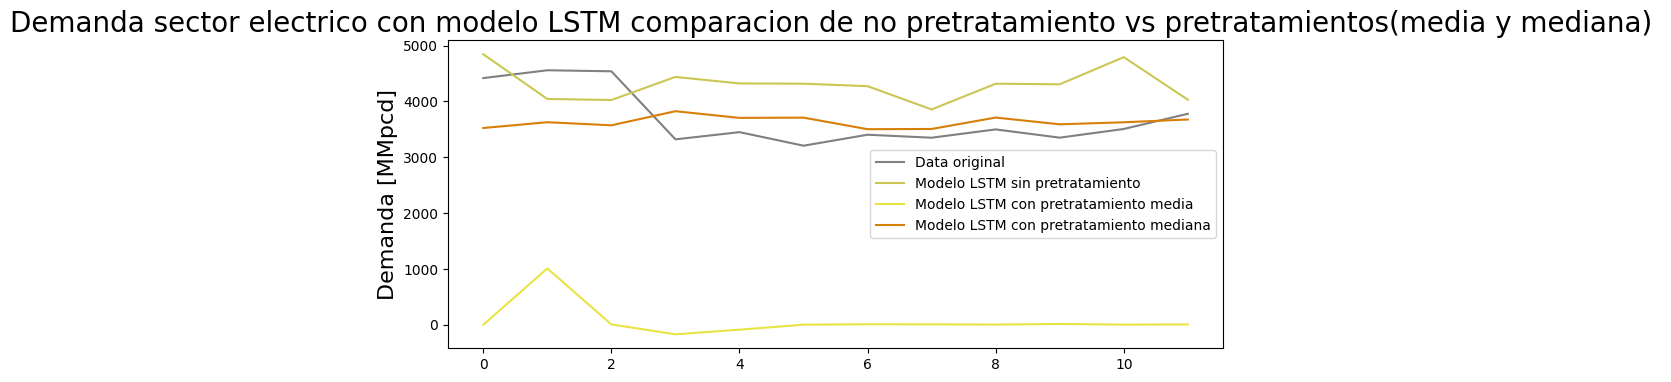

In [99]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana, color='#D77F07' )
plt.legend(('Data original', 'Modelo LSTM sin pretratamiento', 'Modelo LSTM con pretratamiento media', 'Modelo LSTM con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector electrico con modelo LSTM comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [100]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_electrico_pretratamiento_mediana = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_mediana)
RMSE_test_predictions_model_LSTM_electrico_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_mediana))

print('MAPE:', MAPE_test_predictions_model_LSTM_electrico_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_electrico_pretratamiento_mediana)

MAPE: 0.10588802894709975
RMSE: 526.8138455278951


Modelo ARIMA para el caso del pretratamiento de datos con la mediana 

In [101]:
##Create the model
model_ARIMA_electrico_tratamiento_mediana = ARIMA (demanda_electrico_train_pretratamiento_mediana, order=(3,1,3))

##Fit the model
start = time()
model_ARIMA_electrico_tratamiento_mediana_fit = model_ARIMA_electrico_tratamiento_mediana.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_electrico_tratamiento_mediana_fit.summary())

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitting time 1.6859540939331055
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  201
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1411.648
Date:                Mon, 22 Apr 2024   AIC                           2837.297
Time:                        15:55:59   BIC                           2860.385
Sample:                    01-01-2005   HQIC                          2846.640
                         - 09-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1568      0.076    -15.150      0.000      -1.306      -1.007
ar.L2         -0.1866      0.127     -1.474      0.140      -0.435       0.061
ar.L3         

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [102]:
##get prediction start and end dates 
pred_model_ARIMA_electrico_start_date = demanda_electrico_original_test_data.index[0]
pred_model_ARIMA_electrico_end_date = demanda_electrico_original_test_data.index[-1]

In [103]:
##get the predictors and residuals 
predictions_model_ARIMA_electrico_tratamiento_mediana = model_ARIMA_electrico_tratamiento_mediana_fit.predict(start=pred_model_ARIMA_electrico_start_date, end= pred_model_ARIMA_electrico_end_date)
print(predictions_model_ARIMA_electrico_tratamiento_mediana)

2021-10-01    3317.746926
2021-11-01    3251.138025
2021-12-01    3545.527134
2022-01-01    3352.866000
2022-02-01    3496.982287
2022-03-01    3471.513620
2022-04-01    3405.177374
2022-05-01    3538.211397
2022-06-01    3387.588828
2022-07-01    3513.277238
2022-08-01    3443.569432
2022-09-01    3446.881688
Freq: MS, Name: predicted_mean, dtype: float64


In [104]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_electrico_tratamiento_mediana = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_mediana)
RMSE_predictions_model_ARIMA_electrico_tratamiento_mediana= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_electrico_tratamiento_mediana))

print('MAPE:', MAPE_predictions_model_ARIMA_electrico_tratamiento_mediana)
print('RMSE:', RMSE_predictions_model_ARIMA_electrico_tratamiento_mediana)

MAPE: 0.09190050049511662
RMSE: 589.0422988258082


Text(0, 0.5, 'Demanda [MMpcd]')

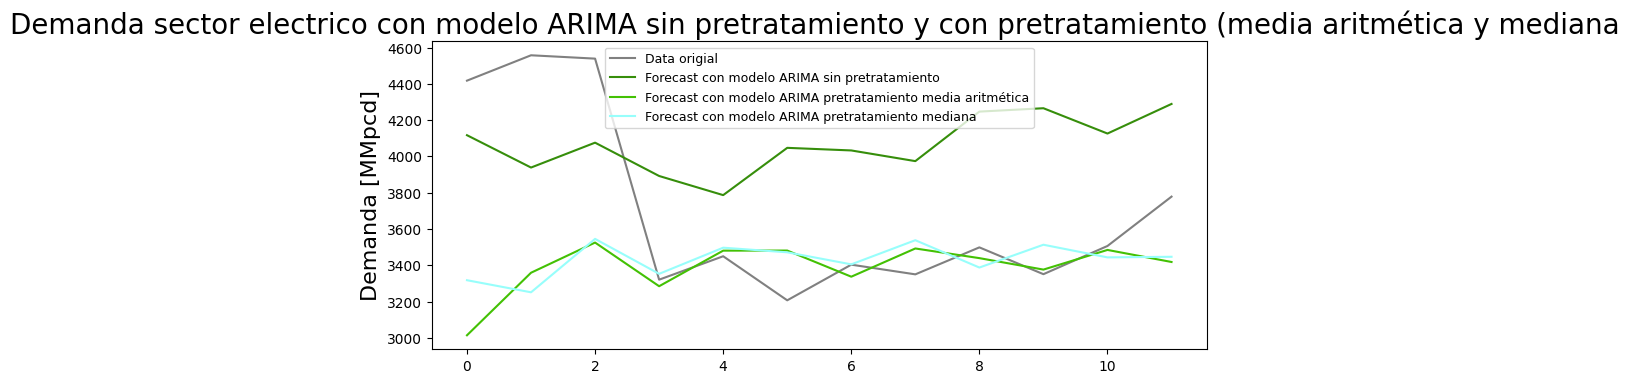

In [105]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')


plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')

plt.plot(predictions_model_ARIMA_electrico_tratamiento_media.values,color='#43C104')
plt.plot(predictions_model_ARIMA_electrico_tratamiento_mediana.values, color='#97FEFB')


plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial','Forecast con modelo ARIMA sin pretratamiento','Forecast con modelo ARIMA pretratamiento media aritmética', 'Forecast con modelo ARIMA pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector electrico con modelo ARIMA sin pretratamiento y con pretratamiento (media aritmética y mediana ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Text(0, 0.5, 'Demanda [MMpcd]')

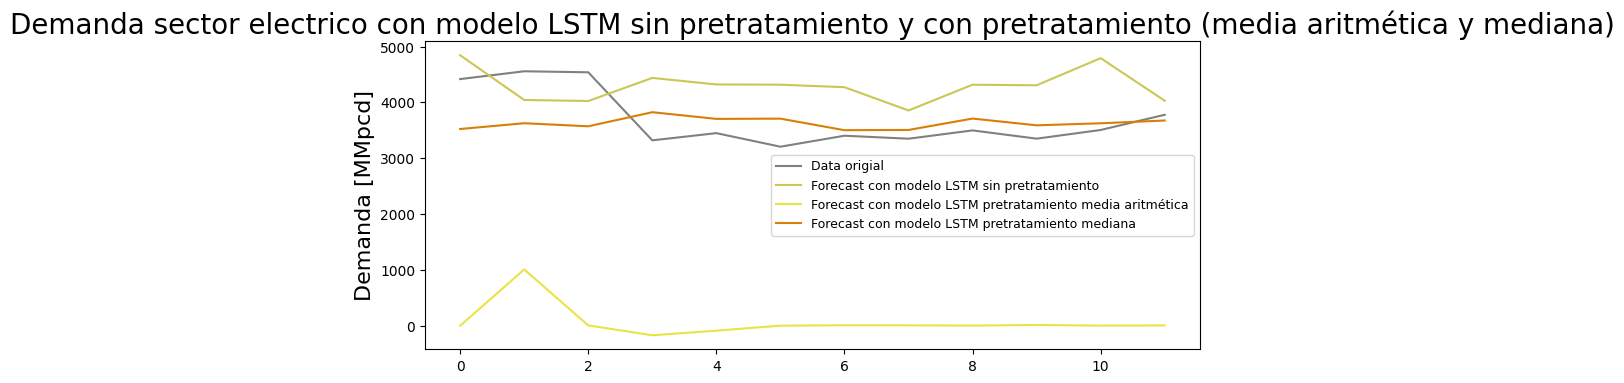

In [106]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')

plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')

plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media , color='#E8E444')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana, color='#D77F07')

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial', 'Forecast con modelo LSTM sin pretratamiento','Forecast con modelo LSTM pretratamiento media aritmética',  'Forecast con modelo LSTM pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media aritmética y mediana)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Text(0, 0.5, 'Demanda [MMpcd]')

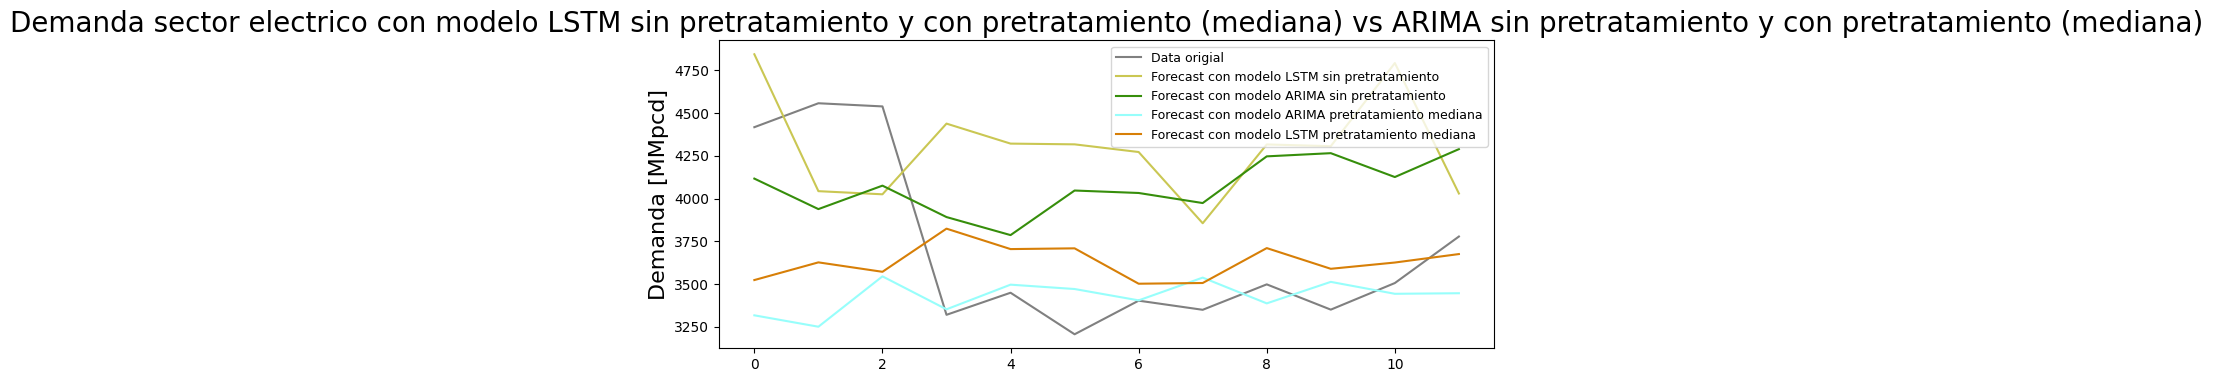

In [107]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='gray')

plt.plot(test_predictions_model_LSTM_electrico, color='#CAC753')


plt.plot(predictions_model_ARIMA_electrico_original.values, color='#368E0B')


plt.plot(predictions_model_ARIMA_electrico_tratamiento_mediana.values, color='#97FEFB')

plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana, color='#D77F07')

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial', 'Forecast con modelo LSTM sin pretratamiento','Forecast con modelo ARIMA sin pretratamiento', 'Forecast con modelo ARIMA pretratamiento mediana' , 'Forecast con modelo LSTM pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (mediana) vs ARIMA sin pretratamiento y con pretratamiento (mediana)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)